In [1]:
import scipy.io
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from os import chdir
chdir('data/Cp_16_05_01')

## experience 1

### Bases de données GPS et vitesse

In [3]:
#Telechargement des données pour l'experience 1 (qui sont sous forme de dictionnaire)
exp_ind = 1
gps1 = scipy.io.loadmat('juan{}_gps.mat'.format(exp_ind))
sensors1 = scipy.io.loadmat('juan{}_etc.mat'.format(exp_ind))

In [4]:
#Mise en forme en Data Frame
gps_df = pd.DataFrame(gps1['GPS'], columns=gps1['GPSFieldsOrder'])
sensors_df = pd.DataFrame(sensors1['SENSORS'], columns=sensors1['ETCFieldsOrder'])

In [5]:
#Changement du nom des variables
gps_df = pd.DataFrame(gps1['GPS'], columns = ['time', 'ts', 'lat', 'long', 'alti', 'course', 'speedOG', 'speedV', 
                                              'SgmLat', 'SgmLong', 'SgmAlti', 'mode', 'sats'])
sensors_df = pd.DataFrame(sensors1['SENSORS'], columns = ['time', 'counts', 'accel', 'steer', 'brake', 'speed'])

In [6]:
#Bien mettre en forme les données 

def readSensorData(sensors_df):
    '''Velocity and steering'''
    # Sensor params
    KV1 = 0.024970 * (1 - 0.21)
    KA1 = 0.00040 * (1 + 0)
    KA0 = 2022
    Kx1 = 1.0127
    Kx2 = 0.0042
    
    time_sensors = sensors_df['time'].values / 1000.
    steering = Kx1 * (sensors_df['steer'].values - KA0) * KA1 + Kx2 
    velocity = KV1 * sensors_df['speed'].values
    
    return time_sensors, steering, velocity


def readGPSData(gps_df):
    '''Latitude and longtitude'''
    # Reference point
    LAT0  = -33.8884
    LONG0 = 151.1948
    
    # Params (wtf is this sorcery)
    a =  6378137.0
    b  = a * (1 - 0.003352810664747)
    kpi = np.pi / 180
    cf = np.cos(LAT0 * kpi)
    sf = np.abs(np.sin(LAT0 * kpi))
    Ro = a ** 2 * cf / np.abs(np.sqrt((a *cf) ** 2 + (b * sf) ** 2))  ;
    RR = b / a  * np.abs(np.sqrt(a ** 2- Ro ** 2)) / sf ;
    
    time_gps = gps_df['time'].values / 1000.
    latitude = - RR * kpi * (gps_df['lat'].values + LAT0)
    longtitude = Ro * kpi * (gps_df['long'].values - LONG0)
    
    return time_gps, latitude, longtitude

In [7]:
def scanData():
    '''
    Pour avoir le temps, le sensor et l'indice de chaque mesure qui arrive
    Au temps time[i] on a une mesure de sensor[i]
    (1 si gps, 2 si steering et velocity)
    dans l'indice index[i] du tableau correspondant
    '''
    time_sensors, steering, velocity = readSensorData(sensors_df)
    time_gps, latitude, longtitude = readGPSData(gps_df)
    
    times = [(1, i, time) for i, time in enumerate(time_gps)]
    times.extend([(2, i, time) for i, time in enumerate(time_sensors)])

    times = np.array(sorted(times, key=lambda u: u[2]))
    time, sensor, index = times[:, 2], times[:, 0], times[:, 1].astype(int)
    return time, sensor, index

In [8]:
#Construction des bases de données finales 
GPSData = pd.DataFrame(readGPSData(gps_df), ['times_GPS', 'latitude', 'longitude']).T
SensorData = pd.DataFrame(readSensorData(sensors_df), ['time_sensors', 'steering', 'velocity']).T

In [9]:
GPSData.head()

,times_GPS,latitude,longitude
0,851.227,-5.707890,6.615680
1,851.428,-5.709734,6.615680
2,851.628,-5.702355,6.614138
3,851.828,-5.700510,6.615680
4,852.028,-5.702355,6.615680


In [10]:
SensorData.head()

,time_sensors,steering,velocity
0,851.292,0.064557,0.0
1,851.317,0.064962,0.0
2,851.342,0.064557,0.0
3,851.367,0.064557,0.0
4,851.392,0.064557,0.0


## Petites visualisations

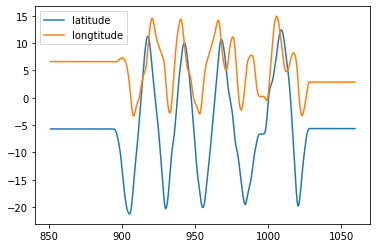

In [11]:
time_gps, latitude, longtitude = readGPSData(gps_df)
plt.plot(time_gps, latitude, label='latitude')
plt.plot(time_gps, longtitude, label='longtitude')
plt.legend()

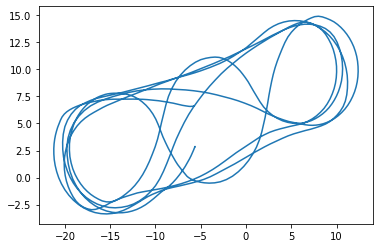

In [12]:
plt.plot(latitude, longtitude)

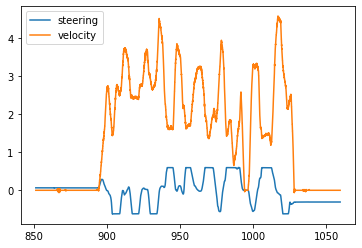

In [13]:
time_sensors, steering, velocity = readSensorData(sensors_df)
plt.plot(time_sensors, steering, label='steering')
plt.plot(time_sensors, velocity, label='velocity')
plt.legend()

### Quelques probas / generateurs aleatoires utiles:

In [102]:
from scipy.stats import dirichlet, multivariate_normal, beta

In [34]:
# Parametres pour le modele de transition (partie bruit)
timestep = (time_sensors[-1] - time_sensors[0]) / (len(time_sensors) - 1)
noise_measures = np.zeros((len(time_sensors) - 2, 2))
# Derivee de la vitesse
noise_measures[:, 0] = (velocity[1:-1] - velocity[:-2]) / timestep
# Derivee seconde de beta
noise_measures[:, 1] = (steering[2:] - 2 * steering[1:-1] + steering[:-2]) / (timestep ** 2)

#Covariance comme esperance
noise_cov = noise_measures.T @ noise_measures / (len(time_sensors) - 2)
noise_mean = np.zeros(2)

Petites sous-fonctions de l'algo final à compléter :

In [ ]:
def q_alpha(alpha_1_prev, c_t, sigma_t) :
    '''
    === ÉQUATION 26 page 11 ===
    Ici, alpha1 est dans {0, 1}. Par l'article, la loi de Dirichlet est réduite
    à une loi beta.
    '''
#     alpha_prime_prev = np.empty(2)
#     alpha_prime_prev[0] = (sigma_t * alpha_1_prev[0] + (c == 0)) / (sigma_t + 1)
#     alpha_prime_prev[1] = (sigma_t * alpha_1_prev[1] + (c == 1)) / (sigma_t + 1)
    
#     rv = dirichlet((1 + sigma_t) * alpha_prime_prev)

    rv = beta(sigma_t * alpha_1_prev + (c == 0))
    
    sampled = rv.rvs()
    proba = rv.pdf(sampled)
    
    
    
    return sampled, proba

In [ ]:
var_gps = 0.002
var_sensors = {'beta': 0.002, 'v': 0.1}

p0_z1 = lambda u: 1e-3 # Uniforme sur un grand intervalle
# Etat de "mauvais" fonctionnement du gps

h1 = lambda state: [state['x'], state['y']]

S = var_gps * np.diag(2) # + ?
# Je dirais = 0 parce que le gradient est nul
# puisque x et y ne dependent du noise qu'au 2nd ordre

def q_c1(x_pred, S1, alpha1, z1) :
    '''
    === ÉQUATION 29 page 11 === 
    '''
    # Probabilite que c_{1, t} = 0:
    p_c_0 = alpha1 *  p0_z1(z1) / (alpha1 *  p0_z1(z1) + (1 - alpha) * multivariate_normal.pdf(z1, h1(x_pred), S1))
    sampled = np.random.binomial(1, p_c_0)
    return sampled, p_c_0 if sampled == 0 else 1 - p_c_0


In [ ]:
# Attention a ca, la densite indiquee dans l'article est bizarre
def q_sigma1 (s1, sigma1_new, sigma1, alpha1_new, alpha1) :
    '''
    === ÉQUATION 28 page 11 ===
    La formule est donnée avec un log.
    Pas de s1 = sigma_{1, t}^alpha ? 
    '''
    lambda_a = 1 * np.random.randn(1) # définir la variance de lambda^alpha, c'est un bruit blanc gaussien
    numerateur = np.random.dirichlet(sigma1_new * alpha1) * (lambda_a * np.random.randn(1) + np.log(sigma1))
    denominateur = np.random.dirichlet(sigma1 * alpha1)
    return numerateur / denominateur

In [22]:
def initilisation_pf(N): #on initialise avec des uniformes sur les espaces de vie des variables
    stretch = 1.02
    
    x_min, x_max = np.min(stretch * latitude), np.max(stretch * latitude)
    y_min, y_max = np.min(stretch * longtitude), np.max(stretch * longtitude)
    v_max = np.max(stretch * velocity)
    beta_min, beta_max = np.min(stretch * steering), np.max(stretch * steering)
    beta_dot = (steering[1:] - steering[:-1]) / (time_sensors[1:] - time_sensors[:-1])
    beta_dot_min, beta_dot_max = np.min(stretch * beta_dot), np.max(beta_dot)
    
    init_state = {
        'x': np.random.uniform(low=x_min, high=x_max, size=N),
        'y': np.random.uniform(low=y_min, high=y_max, size=N),
        'v': np.random.uniform(low=0, high=v_max, size=N),
        'psi': np.random.uniform(low=0, high=2*np.pi, size=N),
        'beta': np.random.uniform(low=beta_min, high=beta_max, size=N),
        'beta_dot': np.random.uniform(low=beta_dot_min, high=beta_dot_max, size=N)
    }
    init_sensor_state = {
        'sigma': np.exp(np.random.normal(0, 1, size=N)), # c'est un peu arbitraire, si vous avez mieux hesitez pas
        'alpha': ,
    }
    init_poids = np.ones(N) / N
    
    return init_state, init_sensor_state, init_poids   

In [82]:
# Geometric constants
L = 2.83
H = 0.76
a = 3.78
b = 0.5

def transition_model(current_state, dt, with_noise=True):
    '''return the state transition model taking into
    account he state noise (v' and beta'')'''
    # Retrieve initial states
    x = current_state['x']
    y = current_state['y']
    v = current_state['v']

    psi = current_state['psi']
    beta = current_state['beta']
    beta_dot = current_state['beta_dot']
    
    # Next states
    next_state = dict()
    next_state['x'] = x + dt * v * (np.cos(psi) + (- a * np.sin(psi) + b * np.cos(psi)) * np.tan(beta) / L)
    next_state['y'] = y + dt * v * (np.sin(psi) + (a * np.cos(psi) + b * np.sin(psi)) * np.tan(beta) / L)
    next_state['v'] = v
    
    next_state['psi'] = psi + dt * v * np.tan(beta) / L
    next_state['beta'] = beta + dt * beta_dot
    next_state['beta_dot'] = beta_dot
    
    if with_noise:
        state_noise = np.random.multivariate_normal(noise_mean, noise_cov, size=x.shape[0])
        next_state['v'] += dt * state_noise[:, 0]
        next_state['beta_dot'] += dt * state_noise[:, 1]

    return next_state

In [83]:


def update_model(N, weights, update_GPS, measures, particles):    
    #Cas GPS
    if update_GPS:
        erreur_mesure = np.linalg.norm([particles['x'] - measures['x'], 
                                        particles['y'] - measures['y']], axis=0)
        for i in range(N): #mise à jour des poids
            weights[i] *= scipy.stats.norm(0, var_gps).pdf(erreur_mesure[i])

    #Cas sensors   
    else:
        erreur_mesure_beta = ((particles['beta'] - measures['beta']) + np.pi) % (2 * np.pi) - np.pi
        erreur_mesure_v = particles['v'] - measures['v']                                  
        for i in range(N): #mise à jour des poids
            weights[i] *= (
                scipy.stats.norm(0, var_sensors['v']).pdf(erreur_mesure_v[i])
                * scipy.stats.norm(0, var_sensors['beta']).pdf(erreur_mesure_beta[i])
            )
    
    weights += 1e-300 # Eviter les divisions par 0
    weights /= sum(weights) # normalize  
        
    return weights
        


In [ ]:
def update_model(N, weights, update_GPS, measures, particles):    
    #Cas GPS
    if update_GPS:
        erreur_mesure = np.linalg.norm([particles['x'] - measures['x'], 
                                        particles['y'] - measures['y']], axis=0)
        for i in range(N): #mise à jour des poids
            weights[i] *= scipy.stats.norm(0, var_gps).pdf(erreur_mesure[i])

    #Cas sensors   
    else:
        erreur_mesure_beta = ((particles['beta'] - measures['beta']) + np.pi) % (2 * np.pi) - np.pi
        erreur_mesure_v = particles['v'] - measures['v']                                  
        for i in range(N): #mise à jour des poids
            weights[i] *= (
                scipy.stats.norm(0, var_sensors['v']).pdf(erreur_mesure_v[i])
                * scipy.stats.norm(0, var_sensors['beta']).pdf(erreur_mesure_beta[i])
            )
    
    weights += 1e-300 # Eviter les divisions par 0
    weights /= sum(weights) # normalize  
        
    return weights

In [84]:
def simple_resample(N, particles, weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.uniform(0, 1, size=N))
    # resample according to indexes
    particles = {key: particles[key][indexes] for key in particles}
    weights.fill(1.0 / N)
    return particles, weights
    

In [85]:
def predictions(weights, particles): #Renvoi la prédiction de l'état à chaque temps
    tab_predict = [sum(particles['x'] * weights), sum(particles['y'] * weights), sum(particles['v'] * weights), 
     sum(particles['beta'] * weights)]
    
    return tab_predict

In [86]:
#Définissons maintenant le corps de l'algo avec les différentes fonctions crées

list_predict=list()

time_sensors, steering, velocity = readSensorData(sensors_df)
time_gps, latitude, longtitude = readGPSData(gps_df)
time, sensor, index = scanData()

def particle_filter(N, skip=1):
    #Initialisation de l'algo
    particles, _, weights = initilisation_pf(N)
    t_previous = time[0]
    
    for i in range(len(time)):
        if i % skip == 0:
            t = time[i] 
            particles = transition_model(particles, dt=t-t_previous)

            update_GPS = sensor[i] == 1
            if update_GPS:
                measures = {'x': latitude[index[i]], 'y': longtitude[index[i]]}
            else:
                measures = {'beta': steering[index[i]], 'v': velocity[index[i]]}

            weights = update_model(N, weights, update_GPS, measures, particles)
            
            # Resampling
            n_eff = 1 / np.sum(weights ** 2)
            if n_eff <= .8 * N:
                print('Resampled')
                particles, weights = simple_resample(N, particles, weights)
            
            t_previous = t
            list_predict.append(predictions(weights, particles))
            
    return list_predict

In [99]:
list_predict = particle_filter(N=3000, skip=50)

In [100]:
len(list_predict)

1282

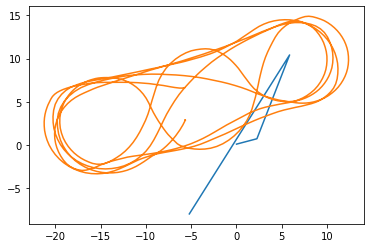

In [101]:
plt.plot(list_predict[:][0], list_predict[:][1])
plt.plot(latitude, longtitude)

# Algorithme 5

Création d'un vecteur temps "à ma façon" :

In [ ]:
S1_time = gps_df['time'].values
S2_time = sensors_df['time'].values
S3_time = laser_df['time'].values

In [ ]:
nb_2_3 = 0
times_2_3 = []

for a in S2_time:
    for b in S3_time:
        if (a == b):
            nb_2_3 += 1
            times_2_3.append(a)
            
print(nb_2_3)

In [ ]:
v_temps = np.ones((len(S1_time) + nb_2_3, 2))
v_temps[0:len(S1_time), 0] = S1_time
v_temps[1040:, 0] = times_2_3
v_temps[1040:, 1] = 23
print(v_temps[1038:1042, :])
v_temps = v_temps[np.argsort(v_temps[:, 0])]

In [ ]:
def calcul_wt (z1, list_c1) :

In [ ]:
def p_z2 () :

In [ ]:
def p_z3 () :

Algorithme :

In [ ]:
def RaoBlackwell_UKF (n_particules, v_temps, eta = 0.8*n_particules):
    
    ### === Initialisation === ###
    
    xhap0 = p_xhap0(x0)
    SIGMA0 = p_SIGMA0(SIG0)
    sigma0 = p_sigma0(sig0)
    alpha0 = p_alpha0(a0, sigma0) # c'est bien sigma0 en deuxième paramètre ?
    w0 = (1./n_particules)*np.ones(n_particules)
    
    ### === Iterations === ###
    
    for t in range (len(time)):
        
        # Mesures z_2,t et z_3,t #
        if (v_temps[t, 1] == 23): 
            
            xchap, SIGMA = UFK(xhap, SIGMA, z2, z3) # en cours (Étienne)
            
            # Update des variables liées au GPS : (à modifier)
            Xt = Xt + T * (Vt*np.cos(psi) + (- a*np.sin(psi) + b*np.cos(psi)) * (Vt/L) * np.tan(beta))
            Yt = Yt + T * (Vt*np.sin(psi) + (a*np.cos(psi) + b*np.sin(psi)) * (Vt/L) * np.tan(beta))
            
            ''' 
            |-----> on ne change rien :
            c1_new = c1
            alpha1_new = alpha1
            sigma1_new = sigma1
            '''
            
            # Update des poids :
            wt = wt * p_z2() * p_z3() # à coder
            
        # Mesures z_1,t #
        if (v_temps[t, 1] == 1) : 
            
            c1_new = q_c1(c1, xchap, SIGMA, alpha1, z1) # à compléter
            alpha1_new = q_alpha1(alpha1, c1_new, sigma1) # fonctionne correctement
            sigma1_new = q_sigma1(s1, sigma1, alpha1_new, alpha1) # à compléter
            xchap, SIGMA = UFK(xhap, SIGMA, c1_new, z1) # en cours (Étienne)
            
            # Update des poids :
            wt = calcul_wt(z1, list_c1) # à coder
            
        # Resampling #
        Neff = 1./sum(wt**2)
        if (Neff <= eta) :
            
            

# A faire (pour avoir l'algo pf et l'algo rao-blackwell):
1 - Sampler le state vector $\tilde{x}_t^{(i)}$ (prendre en compte le state noise), le sensor state variable $\tilde{c}_t^{(i)}$ et les autres pour les particules

2 - Utiliser $\tilde{c}_t^{(i)}$  pour la modelisation du gps

3 - Bien choisir l'importance probability $q$ pour l'algo standard

3 - Trouver la proba cheloue de l'algo Rao-blackwell $p(z_{k,t}|\textbf{z}_{1:t-1})$

4 - Implementer (ou trouver une implementation) de l'UKF

5 - Revoir les distributions initiales $p_0$ (en regardant les histogrammes des mesures par ex)

